In [134]:
import warnings

warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from tqdm.notebook import tqdm
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import VotingClassifier

In [158]:
train = pd.read_csv('./data/train.csv').drop('id', axis=1)
test = pd.read_csv('./data/test.csv').drop('id', axis=1)
sub = pd.read_csv('./data/sample_submission.csv')

In [4]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [5]:
train.shape, test.shape, sub.shape

((19219, 34), (12814, 27), (12814, 8))

In [13]:
ys = list(train.columns[-7:])

In [15]:
Y = train.loc[:, ys]
X = train.drop(ys, axis=1)

In [21]:
X.isna().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

In [24]:
pd.Series(ss.kurtosis(X), index=X.columns)

X_Minimum                 -1.327648
X_Maximum                 -1.257175
Y_Minimum                  8.865337
Y_Maximum                  8.839496
Pixels_Areas             181.689607
X_Perimeter              167.364618
Y_Perimeter                9.289275
Sum_of_Luminosity        121.178595
Minimum_of_Luminosity     -0.003005
Maximum_of_Luminosity      9.781119
Length_of_Conveyer        -1.214170
TypeOfSteel_A300          -1.842475
TypeOfSteel_A400          -1.845782
Steel_Plate_Thickness      5.757569
Edges_Index               -1.206891
Empty_Index               -0.174450
Square_Index              -1.154852
Outside_X_Index           20.005039
Edges_X_Index             -0.779575
Edges_Y_Index             -0.561567
Outside_Global_Index      -1.819354
LogOfAreas                -0.253556
Log_X_Index               -0.064777
Log_Y_Index               -0.173621
Orientation_Index         -1.093678
Luminosity_Index           6.899609
SigmoidOfAreas            -1.637538
dtype: float64

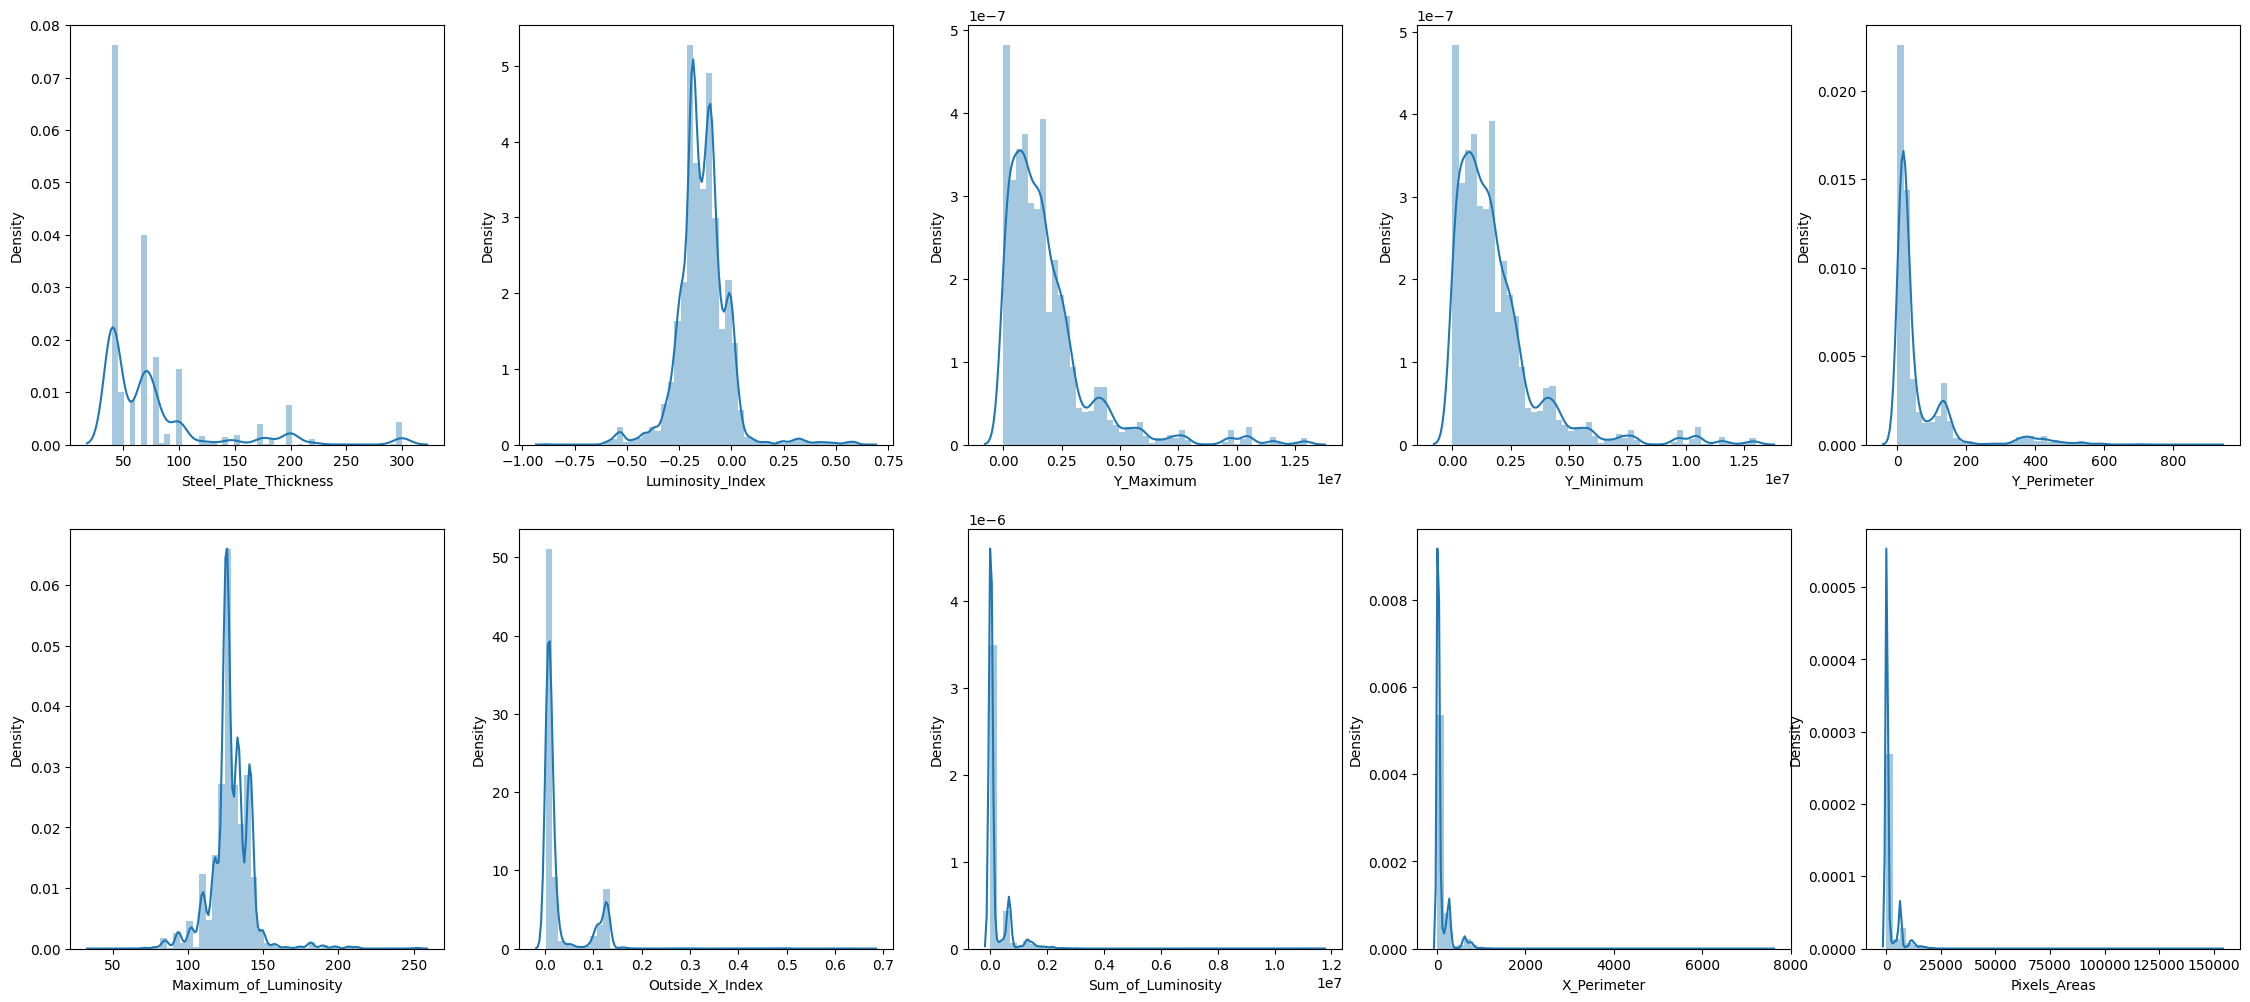

In [38]:
skewed = ['Steel_Plate_Thickness', 'Luminosity_Index', 'Y_Maximum', 'Y_Minimum', 'Y_Perimeter', 'Maximum_of_Luminosity',
          'Outside_X_Index', 'Sum_of_Luminosity', 'X_Perimeter', 'Pixels_Areas']
fig, axs = plt.subplots(2, 5, figsize=(28, 12), dpi=100)
axs = axs.ravel()

for i, c in enumerate(skewed):
    sns.distplot(X[c], ax=axs[i])

plt.show()

In [51]:
pow_trans = YeoJohnsonTransformer(variables=skewed)
X_ = pow_trans.fit_transform(X)

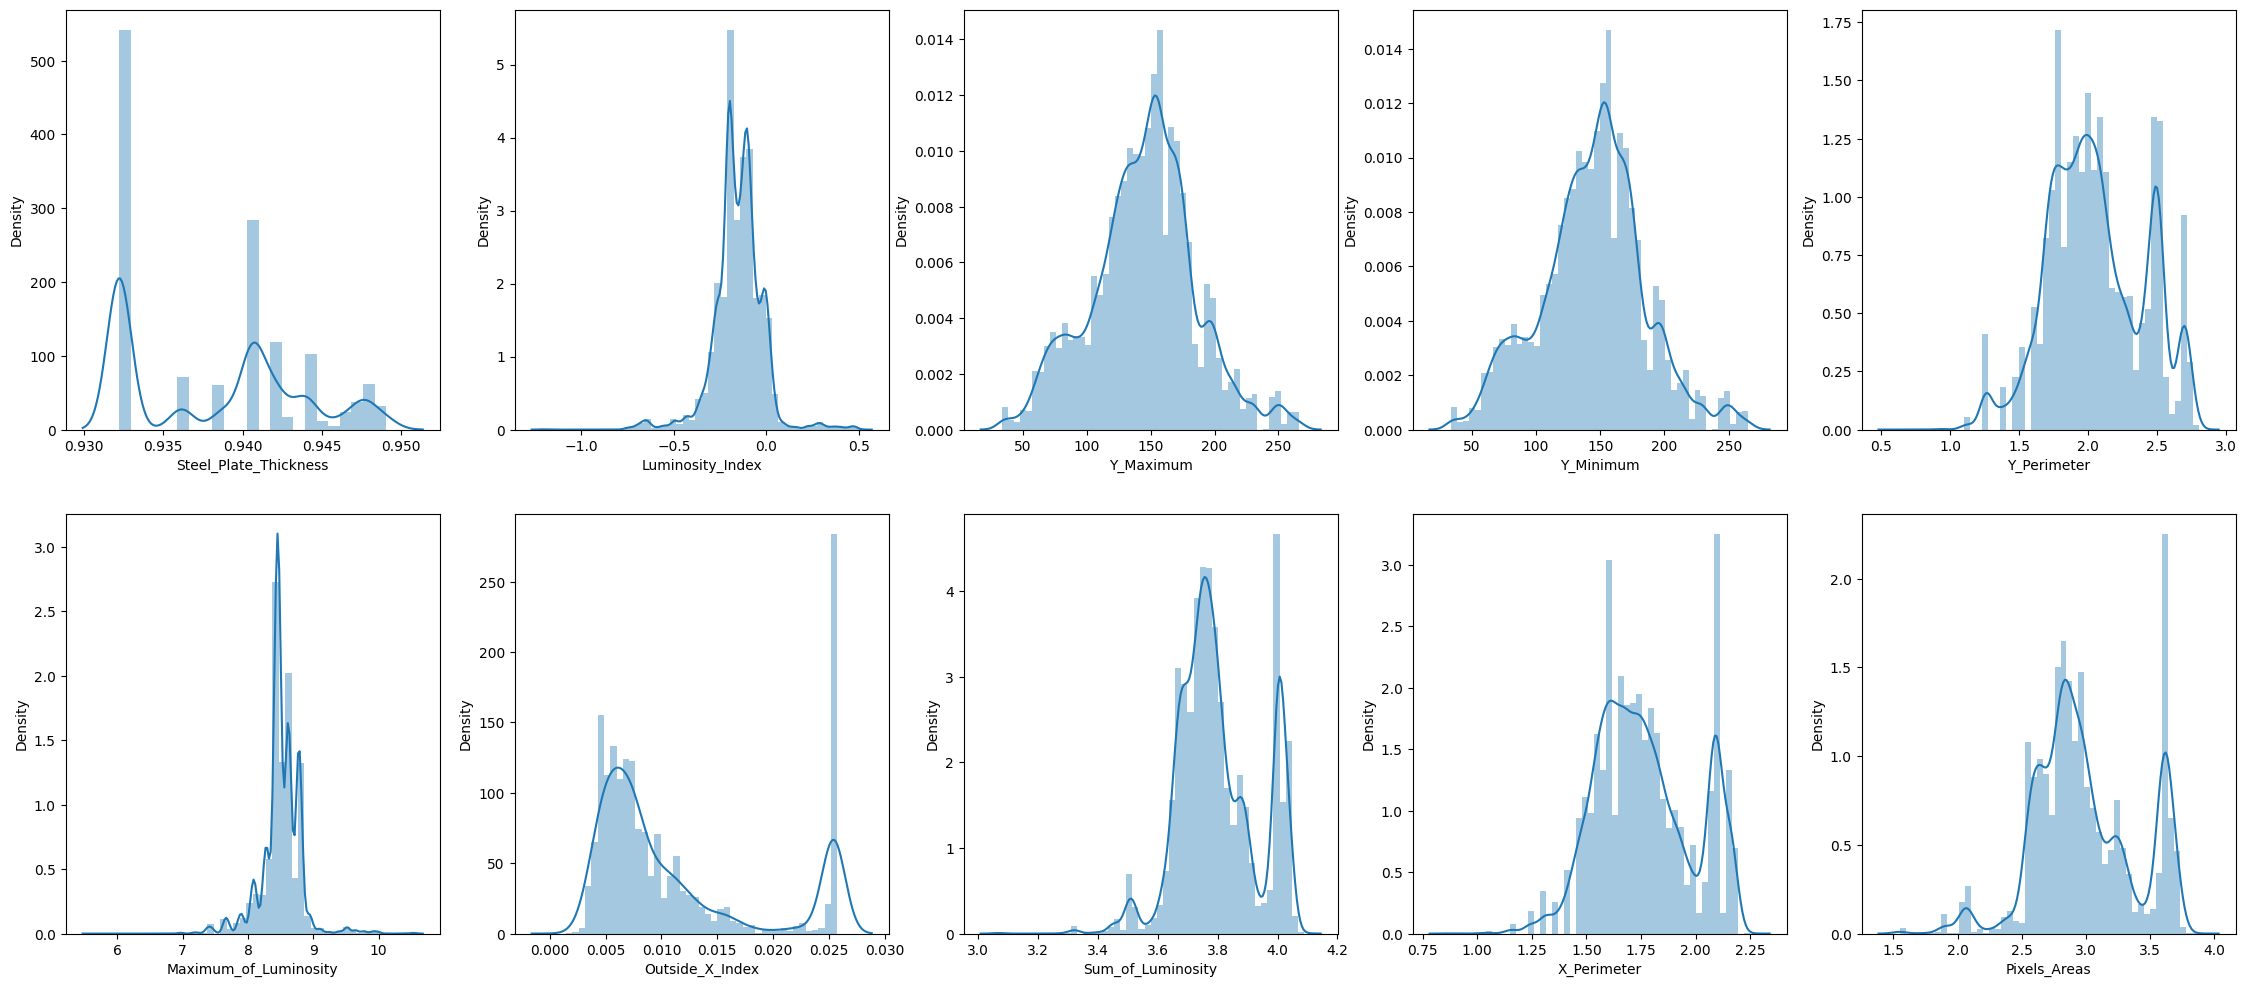

In [54]:
fig, axs = plt.subplots(2, 5, figsize=(28, 12), dpi=100)
axs = axs.ravel()

for i, c in enumerate(skewed):
    sns.distplot(X_[c], ax=axs[i])

plt.show()

In [56]:
test = pow_trans.transform(test)

In [70]:
mut_info = pd.Series(np.zeros((27)), index=X_.columns)

for i in range(7):
    mut_info += pd.Series(mutual_info_classif(X_, Y.iloc[:, i]), index=X_.columns)

mut_info

X_Minimum                0.492857
X_Maximum                0.489631
Y_Minimum                0.244629
Y_Maximum                0.243585
Pixels_Areas             0.525628
X_Perimeter              0.502965
Y_Perimeter              0.484506
Sum_of_Luminosity        0.509728
Minimum_of_Luminosity    0.431898
Maximum_of_Luminosity    0.141609
Length_of_Conveyer       0.403086
TypeOfSteel_A300         0.166404
TypeOfSteel_A400         0.170971
Steel_Plate_Thickness    0.426431
Edges_Index              0.477676
Empty_Index              0.345871
Square_Index             0.392548
Outside_X_Index          0.521541
Edges_X_Index            0.435220
Edges_Y_Index            0.443480
Outside_Global_Index     0.127680
LogOfAreas               0.538301
Log_X_Index              0.495856
Log_Y_Index              0.442489
Orientation_Index        0.454713
Luminosity_Index         0.354534
SigmoidOfAreas           0.469567
dtype: float64

In [78]:
X_['col_1'] = X_['X_Minimum'] / X_['X_Maximum']
X_['col_2'] = X_['Y_Minimum'] / X_['Y_Maximum']
X_['col_3'] = X_['Sum_of_Luminosity'] / X_['Pixels_Areas']
X_['col_4'] = X_['Minimum_of_Luminosity'] / X_['Maximum_of_Luminosity']
X_['col_5'] = X_['X_Perimeter'] / X_['Y_Perimeter']

test['col_1'] = test['X_Minimum'] / test['X_Maximum']
test['col_2'] = test['Y_Minimum'] / test['Y_Maximum']
test['col_3'] = test['Sum_of_Luminosity'] / test['Pixels_Areas']
test['col_4'] = test['Minimum_of_Luminosity'] / test['Maximum_of_Luminosity']
test['col_5'] = test['X_Perimeter'] / test['Y_Perimeter']

In [85]:
min_max = MinMaxScaler()
high_cols = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter',
             'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer']

min_max.fit(X_[high_cols])

MinMaxScaler()

In [87]:
X_[high_cols] = min_max.transform(X_[high_cols])
test[high_cols] = min_max.transform(test[high_cols])

In [90]:
X_.shape, test.shape

((19219, 32), (12814, 32))

In [122]:
def object(trial):
    params = dict(max_iter=trial.suggest_int('max_iter', 200, 1000),
                  alpha=trial.suggest_float('alpha', 1e-3, 1e2),
                  )
    estimator = MultiOutputClassifier(MLPClassifier(**params), n_jobs=-1)
    score = []

    for i, (t_idx, v_idx) in enumerate(cv.split(X_, Y)):
        train_x, valid_x = X_.loc[t_idx, :], X_.loc[v_idx, :]
        train_y, valid_y = Y.loc[t_idx, :], Y.loc[v_idx, :]

        estimator.fit(train_x, train_y)
        score.append(roc_auc_score(valid_y, estimator.predict(valid_x)))

    return np.mean(score)


study = optuna.create_study(direction='maximize')
study.optimize(object, n_trials=100)

[I 2024-03-26 15:33:21,004] A new study created in memory with name: no-name-da19575f-abbc-464d-8cf8-347e906132a5
[I 2024-03-26 15:33:48,357] Trial 0 finished with value: 0.5593997931613968 and parameters: {'max_iter': 421, 'alpha': 10.650639501158778}. Best is trial 0 with value: 0.5593997931613968.
[I 2024-03-26 15:34:16,541] Trial 1 finished with value: 0.5004594068974407 and parameters: {'max_iter': 502, 'alpha': 97.93062989832974}. Best is trial 0 with value: 0.5593997931613968.
[I 2024-03-26 15:34:46,577] Trial 2 finished with value: 0.5562821755358993 and parameters: {'max_iter': 498, 'alpha': 49.16007822696571}. Best is trial 0 with value: 0.5593997931613968.
[I 2024-03-26 15:35:11,514] Trial 3 finished with value: 0.5592999299354257 and parameters: {'max_iter': 480, 'alpha': 11.8162119649704}. Best is trial 0 with value: 0.5593997931613968.
[I 2024-03-26 15:35:40,929] Trial 4 finished with value: 0.5133467179408583 and parameters: {'max_iter': 693, 'alpha': 77.23784887872233}.

In [136]:
estimators = dict(svc=SVC(C=86),
                  knn=KNeighborsClassifier(n_neighbors=3, leaf_size=433),
                  # gpc=GaussianProcessClassifier(kernel=1.0 * RBF(1.0)),
                  tree=DecisionTreeClassifier(max_depth=8, max_leaf_nodes=18, max_features=0.78, ccp_alpha=0.00312),
                  mlp=MLPClassifier(max_iter=650, alpha=0.0412))

In [137]:
preds = []

for _, est in tqdm(estimators.items()):
    model = MultiOutputClassifier(est, n_jobs=-1).fit(X_, Y)
    preds.append(model.predict(test))

  0%|          | 0/4 [00:00<?, ?it/s]

In [156]:
mods, _ = ss.mode(np.asarray(preds))
mods.shape

(12814, 7)

In [164]:
pd.DataFrame(mods, columns=sub.columns[1:]).set_index(sub['id']).to_csv('submission.csv')

In [ ]:
preds = 0
cv = ShuffleSplit(7, test_size=0.2, random_state=48)

for i, (t_idx, v_idx) in enumerate(cv.split(X_, Y)):
    train_x, valid_x = X_.loc[t_idx, :], X_.loc[v_idx, :]
    train_y, valid_y = Y.loc[t_idx, :], Y.loc[v_idx, :]

    estimator = MultiOutputClassifier(SVC(C=3), n_jobs=-1)
    estimator.fit(train_x, train_y)

    print(f"print: {i}")
    print(f"train AUC: {roc_auc_score(train_y, estimator.predict(train_x))}")
    print(f"valid AUC: {roc_auc_score(valid_y, estimator.predict(valid_x))}")
    print("\n")